## Enron Fraud 安隆公司詐欺案資料集
- 安隆公司曾是一間能源公司，2001 年破產前是世界上最大的電力、天然氣及電信公司之一。擁有上千億資產的公司於 2002 年竟然在短短幾周內宣告破產，才揭露其財報在多年以來均是造假的醜聞。在本資料集中你將會扮演偵探的角色，透過高層經理人內部的 mail 來往的情報以及薪資、股票等財務特徵，訓練出一個機器學習模型來幫忙你找到可疑的詐欺犯罪者是誰
- 此專案是藉由mail來往的情報以及薪資、股票等財務特徵來預測犯罪者 poi，True表示是，False表示否。

### 評估
- 嫌犯的預測機率值 (poi)
- 評估指標 AOC

### 特徵定義
- name &rArr; 員工名字。
- bonus &rArr; 根據公司績效反映了支付的年度現金獎勵。也可能包括其他保留付款。
- deferral_payments &rArr; 反映因終止僱傭關係或因計劃規定在職離職而產生的遞延薪酬安排的分配。
- deferred_income &rArr; 由非員工董事自願遞延的工資、年度現金獎勵和長期現金獎勵以及現金費用，就是延遲的薪水。
- director_fees &rArr; 代替現金支付給非員工董事的現金支付和/或股票贈款的價值。
- email_address &rArr; Email信箱。
- exercised_stock_options &rArr; 反映已行使股票期權的金額，等於通過無現金（當日出售）、股票互換或現金行使行使期權之日的市場價值超過行使價的金額。
- expenses &rArr; 反映業務費用的報銷。可能包括支付諮詢服務的費用
- loan_advances &rArr; 反映債務人為換取還款承諾而提供的貸款墊款總額，不包括還款。在某些情況下，條款允許選擇以公司股票償還。。
- long_term_incentive &rArr; 反映了各種長期激勵計劃的長期激勵現金支付，一般3至5年。
- other &rArr; 反映諸如資遣費、諮詢服務、搬遷費用、預繳稅款和國際派遣員工津貼（即住房津貼、生活津貼、安然稅收平衡計劃下的付款等）等項目。
- poi &rArr; 目標值，TRUE為犯罪人。
- restricted_stock &rArr; 反映股票的總市場價值和應計股息。
- restricted_stock_deferred &rArr; 反映遞延的限制性股票的價值。
- salary &rArr; 反映基本工資，現金津貼和福利支付等。
- from_messages &rArr; 通聯記錄。
- to_messages &rArr; 通聯記錄。
- shared_receipt_with_poi &rArr; 與犯罪人共享的信件回覆次數。
- from_poi_to_this_person &rArr; 收到犯罪人的寄信次數。
- from_this_person_to_poi &rArr; 寄信給犯罪人的次數。
- total_payments &rArr; Salary + Bonus + Long Term Incentive + Deferred Income + Deferral Payments + Loan Advances + Othe Expenses + Director Fees 加總的金額 。
- total_stock_value &rArr; Exercised Stock Options + Restricted Stock + Restricted Stock + Deferred 加總的金額 。

In [11]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from scipy.stats import uniform
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 50) 
pd.set_option('display.max_columns', 50) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
pd.set_option('display.precision', 2)

In [12]:
# 載入訓練資料集
train_data = pd.read_csv('./data/Enron Fraud/train_data.csv')
train_data.head(5)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [13]:
# 載入測試資料集
test_features = pd.read_csv('./data/Enron Fraud/test_features.csv')
test_features.head(5)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,108.0,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,raymond.bowen@enron.com,NaN,65907.0,27.0,140.0,15.0,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,david.delainey@enron.com,2291113.0,86174.0,3069.0,66.0,609.0,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,richard.causey@enron.com,NaN,30674.0,49.0,58.0,12.0,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


### 觀察資料
> - 發現只有name與email是字串，poi為布林值
> - 缺失值太多的資料先將其刪除
> - 移除明顯異常的資料, 例如名字非人名
> - 移除明顯無法作為特徵的欄位 name、email_address

In [14]:
# 確認資料特徵類型
print('train_data shape: ' + str(train_data.shape))
print('test_features shape: ' + str(test_features.shape))
print("\n")
train_data.info()

train_data shape: (113, 22)
test_features shape: (33, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       113 non-null    object 
 1   bonus                      61 non-null     float64
 2   deferral_payments          28 non-null     float64
 3   deferred_income            34 non-null     float64
 4   director_fees              13 non-null     float64
 5   email_address              83 non-null     object 
 6   exercised_stock_options    81 non-null     float64
 7   expenses                   73 non-null     float64
 8   from_messages              65 non-null     float64
 9   from_poi_to_this_person    65 non-null     float64
 10  from_this_person_to_poi    65 non-null     float64
 11  loan_advances              2 non-null      float64
 12  long_term_incentive        49 non-null     flo

In [15]:
# 觀察哪些人的缺失值太多的人 例如大於18的，直接將其刪除
nan_index = []
for idx in train_data.index:
    if train_data.iloc[idx, :].isnull().sum()>17:
        nan_index.append(idx)
train_data.iloc[nan_index] 
train_data.drop(nan_index, axis = 0, inplace=True) # axis=0 代表刪除row
print('缺失值過多的欄位 : ' + str(nan_index))

# 觀察資料後發現一個看起來不像人名，另一個則是全都是 NAN，將他們刪除
train_data = train_data[(train_data['name'] != "THE TRAVEL AGENCY IN THE PARK") & (train_data['name'] != "LOCKHART EUGENE E")]

# 確認資料特徵類型
print(f'\ntrain_data shape: {train_data.shape}')


缺失值過多的欄位 : [17, 30, 65, 79, 107]

train_data shape: (108, 22)


In [16]:
# 觀察移除欄位後的資料及尺寸
y_train = train_data['poi']
train_data = train_data.drop(['name','email_address','poi'], axis = 1) # 刪除指定column
test_features = test_features.drop(['name', 'email_address'], axis = 1)


# 合併 train & test 資料集
X = pd.concat([train_data, test_features], ignore_index = True)

print('train_data shape: '+str(train_data.shape))
print('y_train shape: '+str(y_train.shape))
print('test_features shape: '+str(test_features.shape))
print('X shape: '+str(X.shape))

train_data shape: (108, 19)
y_train shape: (108,)
test_features shape: (33, 19)
X shape: (141, 19)


### 異常值檢查與處理 outlier
> - 先用 describe 觀察資料分布
> - 用 boxplot 觀察資料分布
> - 觀察到'restricted_stock_deferred'、‵deferred_income‵、'deferral_payments'、'total_stock_value' 有負的值，推測應該是輸入錯誤，所以先將他修正
> - 箱型圖中異常大的值，判斷可能因詐欺導致異常或是做假帳

In [17]:
X.describe().round(1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.0,39.0,49.0,16.0,100.0,95.0,86.0,86.0,86.0,4.0,66.0,92.0,110.0,18.0,95.0,86.0,86.0,123.0,124.0
mean,2374234.6,1642674.2,-1140475.1,169774.4,6104416.4,108728.9,608.8,64.9,41.2,41962500.0,1470361.5,925119.0,2321741.1,166410.6,562194.3,1176.5,2073.9,5160239.2,6881296.7
std,10713328.0,5161930.0,4025406.4,330140.3,31362885.1,533534.8,1841.0,87.0,100.1,47083208.7,5942759.3,4614026.3,12518278.2,4201494.3,2716369.2,1178.3,2582.7,29292291.5,39263907.9
min,70000.0,-102500.0,-27992891.0,3285.0,3285.0,148.0,12.0,0.0,0.0,400000.0,69223.0,2.0,-2604490.0,-7576788.0,477.0,2.0,57.0,148.0,-44093.0
25%,431250.0,81573.0,-694862.0,83674.5,598891.0,22614.0,22.8,10.0,1.0,1600000.0,281250.0,1209.0,254018.0,-389621.8,211816.0,249.8,541.2,438475.0,507708.8
50%,769375.0,227449.0,-159792.0,106164.5,1343476.5,46950.0,41.0,35.0,8.0,41762500.0,442035.0,51984.5,451740.0,-146975.0,259996.0,740.5,1211.0,1112087.0,1114549.5
75%,1200000.0,1002671.5,-38346.0,112815.0,2563143.2,79952.5,145.5,72.2,24.8,82125000.0,938672.0,360725.5,1002369.8,-75009.8,312117.0,1888.2,2634.8,2097313.5,3073475.8
max,97343619.0,32083396.0,-833.0,1398517.0,311764000.0,5235198.0,14368.0,528.0,609.0,83925000.0,48521928.0,42667589.0,130322299.0,15456290.0,26704229.0,5521.0,15149.0,309886585.0,434509511.0


In [18]:
# 觀察到'restricted_stock_deferred'有負的值，推測應該是輸入錯誤，所以先將他修正
X.loc[X['restricted_stock_deferred'] < 0, 'restricted_stock_deferred'] *= -1.0

X.loc[X['restricted_stock'] < 0, 'restricted_stock'] *= -1.0

X.loc[X['deferred_income'] < 0, 'deferred_income'] *= -1.0

X.loc[X['deferral_payments'] < 0, 'deferral_payments'] *= -1.0

X.loc[X['total_stock_value'] < 0, 'total_stock_value'] *= -1.0

train_data.loc[train_data['restricted_stock_deferred'] < 0, 'restricted_stock_deferred'] *= -1.0
train_data.loc[train_data['restricted_stock'] < 0, 'restricted_stock'] *= -1.0
train_data.loc[train_data['deferred_income'] < 0, 'deferred_income'] *= -1.0
train_data.loc[train_data['deferral_payments'] < 0, 'deferral_payments'] *= -1.0
train_data.loc[train_data['total_stock_value'] < 0, 'total_stock_value'] *= -1.0

In [19]:
X.describe().round(1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.0,39.0,49.0,16.0,100.0,95.0,86.0,86.0,86.0,4.0,66.0,92.0,110.0,18.0,95.0,86.0,86.0,123.0,124.0
mean,2374234.6,1647930.6,1140475.1,169774.4,6104416.4,108728.9,608.8,64.9,41.2,41962500.0,1470361.5,925119.0,2369095.5,1555854.2,562194.3,1176.5,2073.9,5160239.2,6882007.9
std,10713328.0,5160210.2,4025406.4,330140.3,31362885.1,533534.8,1841.0,87.0,100.1,47083208.7,5942759.3,4614026.3,12509321.3,3888290.2,2716369.2,1178.3,2582.7,29292291.5,39263782.2
min,70000.0,7961.0,833.0,3285.0,3285.0,148.0,12.0,0.0,0.0,400000.0,69223.0,2.0,32460.0,32460.0,477.0,2.0,57.0,148.0,28798.0
25%,431250.0,89507.5,38346.0,83674.5,598891.0,22614.0,22.8,10.0,1.0,1600000.0,281250.0,1209.0,260933.5,85725.5,211816.0,249.8,541.2,438475.0,507708.8
50%,769375.0,227449.0,159792.0,106164.5,1343476.5,46950.0,41.0,35.0,8.0,41762500.0,442035.0,51984.5,462822.5,230493.5,259996.0,740.5,1211.0,1112087.0,1114549.5
75%,1200000.0,1002671.5,694862.0,112815.0,2563143.2,79952.5,145.5,72.2,24.8,82125000.0,938672.0,360725.5,1027796.8,456814.5,312117.0,1888.2,2634.8,2097313.5,3073475.8
max,97343619.0,32083396.0,27992891.0,1398517.0,311764000.0,5235198.0,14368.0,528.0,609.0,83925000.0,48521928.0,42667589.0,130322299.0,15456290.0,26704229.0,5521.0,15149.0,309886585.0,434509511.0


ValueError: Could not interpret input 'poi'

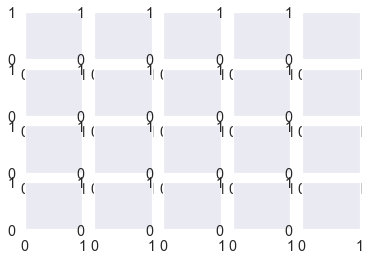

In [20]:
fig, axes = plt.subplots(4, 5)
sns.set(rc={'figure.figsize':(20, 20)})
sns.set(font_scale = 1.3)
sns.boxplot(x = "poi", y = "bonus", data = df_train,ax = axes[0,0], palette='deep')
sns.boxplot(x = "poi", y = "deferral_payments", data = df_train, ax = axes[0,1], palette='deep')
sns.boxplot(x = "poi", y = "deferred_income", data = df_train, ax = axes[0,2], palette='deep')
sns.boxplot(x = "poi", y = "director_fees", data = df_train, ax = axes[0,3], palette='deep')
sns.boxplot(x = "poi", y = "exercised_stock_options", data = df_train, ax = axes[0,4], palette='deep')
sns.boxplot(x = "poi", y = "expenses", data = df_train, ax = axes[1,0], palette='deep')
sns.boxplot(x = "poi", y = "from_messages", data = df_train, ax = axes[1,1], palette='deep')
sns.boxplot(x = "poi", y = "from_poi_to_this_person", data = df_train, ax = axes[1,2], palette='deep')

sns.boxplot(x = "poi", y = "from_this_person_to_poi", data = df_train, ax = axes[1,3], palette='deep')
sns.boxplot(x = "poi", y = "loan_advances", data = df_train, ax = axes[1,4], palette='deep')
sns.boxplot(x = "poi", y = "long_term_incentive", data = df_train, ax = axes[2,0], palette='deep')
sns.boxplot(x = "poi", y = "other", data = df_train, ax = axes[2,1], palette='deep')
sns.boxplot(x = "poi", y = "restricted_stock", data = df_train, ax = axes[2,2], palette='deep')
sns.boxplot(x = "poi", y = "restricted_stock_deferred", data = df_train, ax = axes[2,3], palette='deep')
sns.boxplot(x = "poi", y = "salary", data = df_train, ax = axes[2,4], palette='deep')
sns.boxplot(x = "poi", y = "shared_receipt_with_poi", data = df_train, ax = axes[3,0], palette='deep')
sns.boxplot(x = "poi", y = "to_messages", data = df_train, ax = axes[3,1], palette='deep')
sns.boxplot(x = "poi", y = "total_payments", data = df_train, ax = axes[3,2], palette='deep')
sns.boxplot(x = "poi", y = "total_stock_value", data = df_train, ax = axes[3,3], palette='deep')

plt.tight_layout(h_pad = 3)

### 偏態檢查
- 使用 displot 觀察資料分布狀態
- 去除偏態：透過去除偏態讓資料更接近常態分佈，使用np.log1p 先做數據平滑處理

In [ ]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in Ｘ.columns if Ｘ[feature].dtypes != 'O']
poi = pd.DataFrame(y_train)
feature_numerical.append(poi)
# 觀察所有人的核密度直方圖 查看分布
f, ax = plt.subplots(4, 5, figsize=(15, 15))
i, j  = 0, 0
while i < 4:
    for feature in feature_numerical:
        sns.distplot(Ｘ[feature], ax = ax[i, j], color = '#047794')
        j = j + 1
        if j > 4:
            i = i + 1
            j = 0
            
plt.tight_layout(h_pad = 1)        

In [ ]:
# 去除偏態 將數據做平滑處理
for col in X.columns:
        X.loc[X[col].notna(), col] = np.log1p(X.loc[X[col].notna(), col])
        
# 觀察所有人的核密度直方圖 查看分布
f, ax = plt.subplots(4, 5, figsize=(15, 15))
i, j  = 0, 0
while i < 4:
    for feature in feature_numerical:
        sns.distplot(Ｘ[feature], ax = ax[i, j], color = '#047794')
        j = j + 1
        if j > 4:
            i = i + 1
            j = 0
            
plt.tight_layout(h_pad = 1)        

### 缺失值 Missing value 檢查
> - 發現部分特徵都缺少0這個值, 因此我判斷nan就是0
> - 'from_poi_to_this_person','from_this_person_to_poi'這兩個都有0, 使用平均值來補

In [ ]:
# 定義缺失值檢測函數
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('Missing values',ascending=False)
    
    return mis_val_rename

missing_value_table(X).plot(kind="bar", figsize = (15,6), fontsize = 10)
plt.xticks(rotation=50, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("missing value count", fontsize = 20)

In [ ]:
# 先取得都是 nan 沒有 0 的特徵陣列
features_NaN_to_0 = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 
                     'expenses', 'from_messages', 'loan_advances', 'long_term_incentive', 'other', 
                     'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 
                     'to_messages', 'total_payments', 'total_stock_value']

# 再取得需特殊處理的特徵: from_poi_to_this_person
average_from_poi_to_this_person = X['from_poi_to_this_person'].mean()
std_from_poi_to_this_person = X['from_poi_to_this_person'].std()
nan_count_from_poi_to_this_person = X['from_poi_to_this_person'].isnull().sum()
random_from_poi = np.random.RandomState(42).randint(
                 average_from_poi_to_this_person - std_from_poi_to_this_person, 
                 average_from_poi_to_this_person + std_from_poi_to_this_person, 
                 size = nan_count_from_poi_to_this_person)

# 再取得需特殊處理的特徵: from_this_person_to_poi
average_from_this_person_to_poi = X['from_this_person_to_poi'].mean()
std_from_this_person_to_poi = X['from_this_person_to_poi'].std()
nan_count_from_this_person_to_poi = X['from_this_person_to_poi'].isnull().sum()
random_to_poi = np.random.RandomState(42).randint(
                 average_from_this_person_to_poi - std_from_this_person_to_poi, 
                 average_from_this_person_to_poi + std_from_this_person_to_poi, 
                 size = nan_count_from_this_person_to_poi)

# 填補缺失值
for column in X.columns:
    if column in features_NaN_to_0:
        X[column] = X[column].fillna(0)
    elif column == 'from_poi_to_this_person':
        X.loc[np.isnan(X[column]), column] = random_from_poi
    elif column == 'from_this_person_to_poi':
        X.loc[np.isnan(X[column]), column] = random_to_poi
        
# X['from_poi_to_this_person'] = X['from_poi_to_this_person'].fillna(X['from_poi_to_this_person'].median())             
# X['from_this_person_to_poi'] = X['from_this_person_to_poi'].fillna(X['from_this_person_to_poi'].median())        

### EDA (Exploratory Data Analysis) 探索式資料分析 : 高相關性
> - 紅色為 詐欺者, 藍色為 一般職員
> - 用 displot 觀察資料分布  
> - 是詐欺者的職員, bonus越高, 但是bonus最高的一位為一般職員, 要馬沒有被抓, 要馬他真的厲害!!
> - 延誤的薪資越高, 為詐欺者的機率越高
> - 股票選擇權金額越高, poi機率越高
> - 長期獎勵計劃的金額, 平均詐欺者的金額較高, 但金額最高區段部份的人持平
> - 股票價值與薪資等等相關的數據, 明顯都是詐欺者越高

In [ ]:
df_train = train_data.copy()
df_train = pd.concat([df_train, pd.DataFrame(y_train)], axis = 1)

# 取得相關性絕對值大於 0.2 的特徵
high_corr_feature_select = []
low_corr_feature_select = []

for i in range(len(df_train.astype(float).corr()['poi'])):
    if abs(df_train.astype(float).corr()['poi'].values[i] >= 0.2):
        high_corr_feature_select.append(df_train.astype(float).corr()['poi'].index[i])
    else:
        low_corr_feature_select.append(df_train.astype(float).corr()['poi'].index[i])
        
# 觀察數值類型的特徵
plt.figure(figsize=(20,20))
sns.set(font_scale = 1.5)
# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(high_corr_feature_select):
    if source == 'poi':
        continue
    # 指定好子圖的位置 
    plt.subplot(5, 2, i+1)
    # kdeplot
    sns.distplot(df_train.loc[df_train['poi']==0, source], color = '#047794').set(xlabel=None)
    sns.distplot(df_train.loc[df_train['poi']==1, source], color = 'r').set(xlabel=None)
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 : 低相關性
> - 紅色為 詐欺者, 藍色為 一般職員
> - 發現詐欺者並不會有遞延的限制性股票, 也沒有董事費

In [ ]:
# 觀察數值類型的特徵
plt.figure(figsize=(20,20))
sns.set(font_scale = 1.5)
# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(low_corr_feature_select):
    # 指定好子圖的位置 
    plt.subplot(5, 2, i+1)
    # kdeplot
    sns.distplot(df_train.loc[df_train['poi']==0, source], color = '#047794').set(xlabel=None)
    sns.distplot(df_train.loc[df_train['poi']==1, source], color = 'r').set(xlabel=None)
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 (特別關注)
> - 薪資與bonu的關係 : 薪資最高的兩個是詐欺者, 能明顯看出薪資越高bonus越高
> - 從 total_payments 與 total_stock_value 的關係中可以發現, 薪資與股價價值幾乎最高的那位就是詐欺者, payment不高, 但股票價值超高的有高機率是詐欺者
> - 從信件往來可以看出, 最密切往來的那個人沒有問題, ㄠ

In [ ]:
sns.set(rc={'figure.figsize':(20, 10)})
fig, axes = plt.subplots(1, 2)
# salary v.s. bonus
sns.scatterplot(x = 'salary', y = 'bonus', hue="poi", data = df_train, palette='deep', ax = axes[0])

# total_payments v.s. total_stock_value
df_train= df_train.drop(df_train[df_train['total_payments'] > 100000000].index) # payment中有一個值太大 影響判斷 先將它拿掉
sns.scatterplot(x = 'total_payments', y = 'total_stock_value', hue="poi", data = df_train, palette='deep', ax = axes[1])



In [ ]:
sns.set(rc={'figure.figsize':(20, 10)})
fig, axes = plt.subplots(1, 2)

# 觀察信件相關
sns.scatterplot(x = 'from_this_person_to_poi', y = 'from_poi_to_this_person', hue="poi", data = df_train, palette='deep', ax = axes[0])

# 觀察與詐欺者信件往來
sns.scatterplot(x = 'expenses', y = 'other', hue="poi", data = df_train, palette='deep', ax = axes[1])

## 特徵工程

#### 1. 特徵建構

In [ ]:
# 將薪水與股票價值加總
X['total_incomes']= X['total_payments'] + X['total_stock_value']

# 將延期薪水與延期股票加總
X['total_deferred']= X['deferral_payments'] + X['deferred_income'] + X['restricted_stock_deferred']

# 計算薪資總額
X['total_payments_recount'] = X['deferred_income'] + X['bonus'] + X['deferral_payments'] + X['director_fees'] + X['expenses'] + X['loan_advances'] + X['long_term_incentive']+ X['other'] +X['salary']
    
# 計算薪資總額誤差: 出現誤差, 表示有人作假帳 
X['total_payments_error'] = X['total_payments_recount'] - X['total_payments']

# 計算股票總和 
X['total_stock_value_recount'] = X['restricted_stock_deferred'] + X['exercised_stock_options'] + X['restricted_stock']

# 計算股票總和誤差
X['total_stock_value_error'] = X['total_stock_value_recount'] - X['total_stock_value']

# email : 詐欺相關
X['total_poi_contact'] = X['from_poi_to_this_person'] + X['from_this_person_to_poi']

# email : 一般通訊
X['total_messages'] = X['from_messages'] + X['to_messages']

#### 2. 特徵提取

In [ ]:
# 將數值特徵分成五等分，精簡模型的數值分析，並做 LabelEncoder
for column in X.columns:
    X[column] = pd.cut(X[column], 5)
    X[column] = LabelEncoder().fit_transform(X[column])
X.head(10)

#### 3.特徵選擇
- 使用皮爾遜積差相關係數來做特徵選擇

In [ ]:
# 因為剛剛把 poi 移除了, 所以先加回來判斷相關係數
X_train = X[:train_data.shape[0]]
y_train = pd.DataFrame(y_train)
train = pd.concat([X_train, pd.DataFrame(y_train)], axis = 1)

# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

In [ ]:
# 觀察相關性
train.astype(float).corr()['poi'].sort_values()

In [ ]:
# 取得相關性絕對值大於 0.2 的特徵
feature_select = []
for i in range(len(train.astype(float).corr()['poi'])):
    if abs(train.astype(float).corr()['poi'].values[i] >= 0.20):
        feature_select.append(train.astype(float).corr()['poi'].index[i])

# 刪除較不相關的欄位
for column in X.columns:
    if column not in feature_select:
        X = X.drop([column], axis = 1)
        
# 觀察修正後的訓練資料尺寸
print(f'X shape: {X.shape}')

## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞

In [ ]:
X_train = X[:train_data.shape[0]]
y_train = y_train
X_test = X[train_data.shape[0]:]
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')

## 資料標準化

In [ ]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_test_mm = mm.transform(X_test)

## 訓練模型

### Logistic Regression 邏輯斯迴歸

In [ ]:
model_LogisticRegression = LogisticRegression()

# 先對模型做交叉驗證，並找出最佳參數
parameters = dict(
                    C=range(1, 15),
                    max_iter=range(1, 100)
                 )

model_LogisticRegression_rs = RandomizedSearchCV(model_LogisticRegression, parameters, random_state=0, n_iter=10, cv=10).fit(X_train, y_train)

model_LogisticRegression_rs.best_params_

model_LogisticRegression = LogisticRegression(random_state=42, C = model_LogisticRegression_rs.best_params_['C'], max_iter = model_LogisticRegression_rs.best_params_['max_iter'])
model_LogisticRegression.fit(X_train_mm, y_train)

print('Logistic Regression Training score:', model_LogisticRegression.score(X_train_mm, y_train).round(2))

#測試測試集
y_test_predict_logreg = model_LogisticRegression.predict(X_train_mm)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_train, y_test_predict_logreg)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", ((cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])).round(2) )
print("精確率（Precision）: ", ((cm[0][0])/(cm[0][0] + cm[0][1])).round(2) )
print("召回率（Recall）: ", ((cm[0][0])/(cm[0][0] + cm[1][1])).round(2) )
print("AUC : ", roc_auc_score(y_train, y_test_predict_logreg).round(2) )

### Random Forest 隨機森林

In [ ]:
model_rf = RandomForestClassifier()

# 先對模型做交叉驗證，並找出最佳參數
parameters = dict(
                    n_estimators=range(1, 10),
                    max_depth=range(1, 10)
                 )

model_rf_rs = RandomizedSearchCV(model_rf, parameters, random_state=0, n_iter=10).fit(X_train, y_train)
model_rf_rs.best_params_

model_rf = RandomForestClassifier(
    n_estimators = model_rf_rs.best_params_['n_estimators'],
    max_depth = model_rf_rs.best_params_['max_depth']
)

model_rf.fit(X_train_mm, y_train)

print('Random Forest Training score:', model_rf.score(X_train_mm, y_train).round(2))

y_test_predict_rf = model_rf.predict(X_train_mm)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_train, y_test_predict_rf)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", ((cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])).round(2) )
print("精確率（Precision）: ", ((cm[0][0])/(cm[0][0] + cm[0][1])).round(2) )
print("召回率（Recall）: ", ((cm[0][0])/(cm[0][0] + cm[1][1])).round(2) )
print("AUC : ", roc_auc_score(y_train, y_test_predict_rf).round(2) )

### LightGBM 

In [ ]:
model_lgb = lgb.LGBMClassifier()

parameters = {
        'n_estimators':range(1, 200, 1),
        'max_depth':range(1, 200, 1),
        'min_data_in_leaf':range(1, 100, 1)
        }

model_lgb_rs = RandomizedSearchCV(model_lgb, parameters, random_state=0, n_iter=10, cv=10).fit(X_train, y_train)

print(model_lgb_rs.best_params_)

model_lgb = lgb.LGBMClassifier(
    n_estimators = model_lgb_rs.best_params_['n_estimators'],
    max_depth = model_lgb_rs.best_params_['max_depth'],
    min_data_in_leaf = model_lgb_rs.best_params_['min_data_in_leaf']
  )

model_lgb.fit(X_train_mm, y_train)

print('LightGBM Training score:', model_lgb.score(X_train_mm, y_train).round(2))

y_test_predict_lgb = model_lgb.predict(X_train_mm)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_train, y_test_predict_lgb)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", ((cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])).round(2) )
print("精確率（Precision）: ", ((cm[0][0])/(cm[0][0] + cm[0][1])).round(2) )
print("召回率（Recall）: ", ((cm[0][0])/(cm[0][0] + cm[1][1])).round(2) )
print("AUC : ", roc_auc_score(y_train, y_test_predict_lgb).round(2) )

## 測試模型並輸出結果

In [ ]:
y_test_predict_logreg = model_LogisticRegression.predict_proba(X_test_mm)[:, 1]
y_test_predict_rf = model_rf.predict_proba(X_test_mm)[:, 1]
y_test_predict_lgb = model_lgb.predict_proba(X_test_mm)[:, 1]

In [ ]:
# 看一下模型預測差異
predict_result = pd.DataFrame()
predict_result['Logistic Regression'] = y_test_predict_logreg
predict_result['Random Forest'] = y_test_predict_rf
predict_result['LightGBM'] = y_test_predict_lgb
predict_result.head()

In [ ]:
sub = pd.read_csv('./data/Enron Fraud/sample_submission.csv')
submission = pd.DataFrame()
submission['name'] = sub['name']
submission['poi'] = y_test_predict_lgb 
submission.to_csv('./data/Enron Fraud/submission_lgb_pred.csv', index = False)